In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Sequence, Callable, NewType
import random
from numpy.random import default_rng
from collections import defaultdict
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
def adf(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    a = len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

MalwareClass = NewType('MalwareClass', [int, int])

def lcl(a:int, labels) -> MalwareClass:
    return [[0, 1], [1, 0]][labels[a]]


def create_voting_net(gamma: float, 
                      apns: Sequence[int], 
                      distance: Callable[[int,int], float], 
                      classifier: Callable[[int], MalwareClass ]):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                net[n] = list(np.add(net[n],classifier(a)))
                break  # does it always belong to only one point? probably
        if insert:
            net[a] = classifier(a)

    return net


def create_aggregating_net(gamma: float, apns: Sequence[int], distance: Callable[[int, int], float]):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) < gamma:
                insert = False
                net[n].append(a)
                break  
        if insert:
            net[a] = list()

    return net

def merge_voting_nets_new(nets, distance, gamma):
    apns = []
    for net in nets:
        apns += list(net.keys())

    nn = create_aggregating_net(gamma=gamma,
                                apns=apns,
                                distance=distance)
    
    # transfer the "votes" from original networks to just created new anchors
    targ = dict()
    for k, v in nn.items():
        for net in nets:
            if k in net:
                targ[k] = net.get(k)
                break

        for el in v:
            for net in nets:
                if el in net:
                    targ[k] = list(np.add(targ[k], net[el]))
                    break

    return targ

def merge_voting_nets(nets, distance, gamma):
    apns = []
    for net in nets:
        apns += list(net.keys())

    nn = create_aggregating_net(gamma=gamma,
                                apns=apns,
                                distance=distance)
    targ = defaultdict(lambda: [0, 0])

    for k, v in nn.items():
        for net in nets:
            targ[k] = [i+j for i, j in zip(targ[k], net.get(k, [0, 0]))]

        for el in v:
            for net in nets:
                targ[k] = [i+j for i, j in zip(targ[k], net.get(el, [0, 0]))]
            #targ[k] = [i+j for i,j in zip(targ[k], convert_to_voting([el], labels))]

    return dict(targ)

### Lambda overhead


In [261]:
from functools import partial

def afunc(x,y,z):
    return x*y+2**z

lfunc = lambda x,y: afunc(x,y, 5)
pfunc = partial(afunc, z=5)

In [287]:
a = np.random.randint(0, 100, size=500)
b = np.random.randint(0, 100, size=500)

In [296]:
%timeit res = [afunc(x,y,5) for (x,y) in zip(a,b)]

438 µs ± 7.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [297]:
%timeit res = [lfunc(x,y) for (x,y) in zip(a,b)]

462 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [298]:
%timeit res = [pfunc(x,y) for (x,y) in zip(a,b)]

502 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Data preparation

In [6]:
def join_tables(funcs, labels):
    lapns = labels.set_index('apn')
    gj = lapns.join(funcs)
    gj.dropna(inplace=True)
    gj['mal'] = gj.malware_label.astype(int)
    return gj.drop('malware_label', axis=1)

def get_part_indexes(dfs, num_parts, size):
    rn = default_rng(42)
    permuted_indices = rn.permutation(dfs.size)
    return [permuted_indices[i:i+size] for i in range(0, size*num_parts, size)]

def countin_decorator(func):
    def inner(*args, **kwargs):
        inner.calls +=1
        return func(*args, **kwargs)
    inner.calls = 0
    return inner

In [7]:
labels = pd.read_csv('data/labels_encoded.csv')

v = pd.read_csv('data/functions_encoded.csv')
funcs = v.groupby(by='apn')['nf'].apply(set)


In [8]:
geef = join_tables(funcs=funcs, labels=labels)

afs = geef['nf'].to_numpy()
lbs = geef['mal'].to_numpy()

In [9]:
@countin_decorator
def mydistance(x,y):
    return adf(x,y,afs)

### Complexity
Number of distance calculations to merge a network
1. in one shot
1. in a hierarchical manner

Setup:
1. 8 partition are created, for each partition a $\gamma$-network is created
2. they are merged either in oneshot manner or hierarchical (pairwise)
3. for each merging number of calls of the distance function are counted
4. for hierarchical merging, then number of operation is differentiated by the merging phases 
5. for hierarchical merging the size of the intermediate networks is recorded

Outcome:
Hierarchical merging requires more operations

Explaination:
The actual compression is happening in the network creation phase, the merging phase increases the number of anchors (reduces the compression). It makes sense as different partitions contribute more "knowledge" to the overal mix. 
Thus, the merge of the last two networks takes almost as much time as the one shot merge. 

In [7]:
def evaluate_oneshot_mergings(vnets, gamma):
    mydistance.calls = 0
    mvo2 = merge_voting_nets_new(nets=vnets, distance=mydistance, gamma=gamma)
    one_shot_operations = mydistance.calls
    return one_shot_operations

In [8]:
def evaluate_hierarchical_mergings(vnets, gamma):
    mydistance.calls =0
    nets = vnets.copy()
    sizes = dict()
    operations = dict()
    while len(nets) > 1:
            sizes[len(nets)] = [len(n.keys()) for n in nets]
            b = zip(nets[::2], nets[1::2])
            nets = [merge_voting_nets_new(nets=bi, distance=mydistance, gamma=gamma) for bi in b]
            operations[len(nets)] = mydistance.calls
            mydistance.calls = 0
    
    return operations, sizes

In [ ]:
num_parts = 8
part_size = 100
parts = get_part_indexes(afs, num_parts, part_size)

res = dict()

for gamma in tqdm([0, 2, 4, 8, 16]):
    vnets = [create_voting_net(gamma=gamma, apns=part, 
                               distance=mydistance, 
                               classifier=lambda x: lcl(x, labs)) for part in parts]
    one_shot_ops = evaluate_oneshot_mergings(vnets, gamma)
    operations, sizes = evaluate_hierarchical_mergings(vnets, gamma)
    res[gamma] = [one_shot_ops, operations, sizes]

In [487]:
rdf = pd.DataFrame.from_dict(res, orient='index', columns=['one_shot_ops', 'hierarchical_ops', 'hierarchical_sizes'])
rdf.to_csv(f"res/new_complexity_{num_parts}_{part_size}size.csv")

In [29]:
rdf = pd.read_csv('res/new_complexity_8_100size.csv', index_col=0)
rdf.hierarchical_ops = rdf.hierarchical_ops.apply(eval)
rdf.hierarchical_sizes = rdf.hierarchical_sizes.apply(eval)

In [35]:
rdf

,one_shot_ops,hierarchical_ops,hierarchical_sizes,hierarchical_ops_ov,size_stage1,size_stage2,size_stage3
0,126619,"{4: 40950, 2: 69107, 1: 115796}","{8: [83, 83, 72, 69, 68, 72, 75, 81], 4: [156,...",225853,75.375,141.00,256.5
2,98983,"{4: 33254, 2: 56031, 1: 90176}","{8: [72, 75, 65, 64, 59, 67, 71, 74], 4: [138,...",179461,68.375,127.25,231.0
4,79453,"{4: 26677, 2: 44946, 1: 72606}","{8: [65, 65, 62, 57, 52, 60, 65, 66], 4: [123,...",144229,61.500,114.00,207.0
8,58714,"{4: 20321, 2: 33513, 1: 54171}","{8: [59, 58, 53, 49, 45, 52, 58, 57], 4: [109,...",108005,53.875,99.25,179.0
16,43225,"{4: 14674, 2: 24835, 1: 40386}","{8: [49, 52, 45, 41, 41, 46, 48, 47], 4: [93, ...",79895,46.125,84.75,155.0


In [30]:
rdf['hierarchical_ops_ov'] = rdf.hierarchical_ops.apply(lambda x: np.sum([ki for ki in x.values()]))
rdf['size_stage1'] = rdf.hierarchical_sizes.apply(lambda x: np.mean([ki for ki in x[8]]))
rdf['size_stage2'] = rdf.hierarchical_sizes.apply(lambda x: np.mean([ki for ki in x[4]]))
rdf['size_stage3'] = rdf.hierarchical_sizes.apply(lambda x: np.mean([ki for ki in x[2]]))


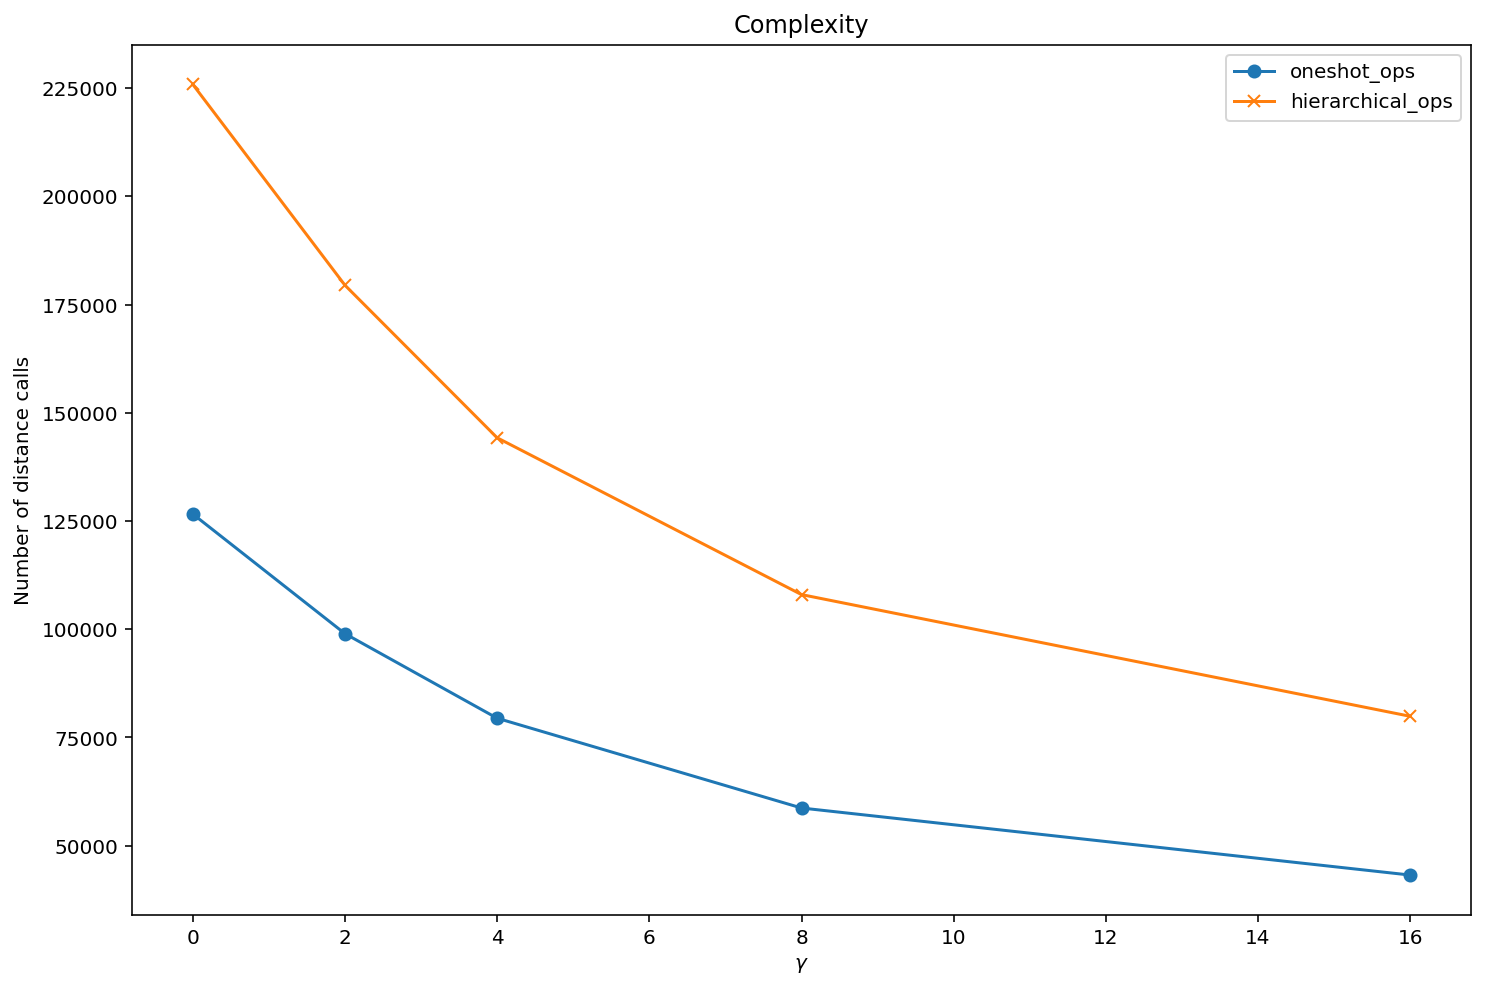

In [32]:
plt.figure(figsize=(12,8))
plt.plot(rdf.one_shot_ops,'-o', label='oneshot_ops')
plt.plot(rdf.hierarchical_ops_ov,'-x', label='hierarchical_ops')
plt.legend();
plt.xlabel(r"$\gamma$")
plt.ylabel("Number of distance calls");
plt.title('Complexity');

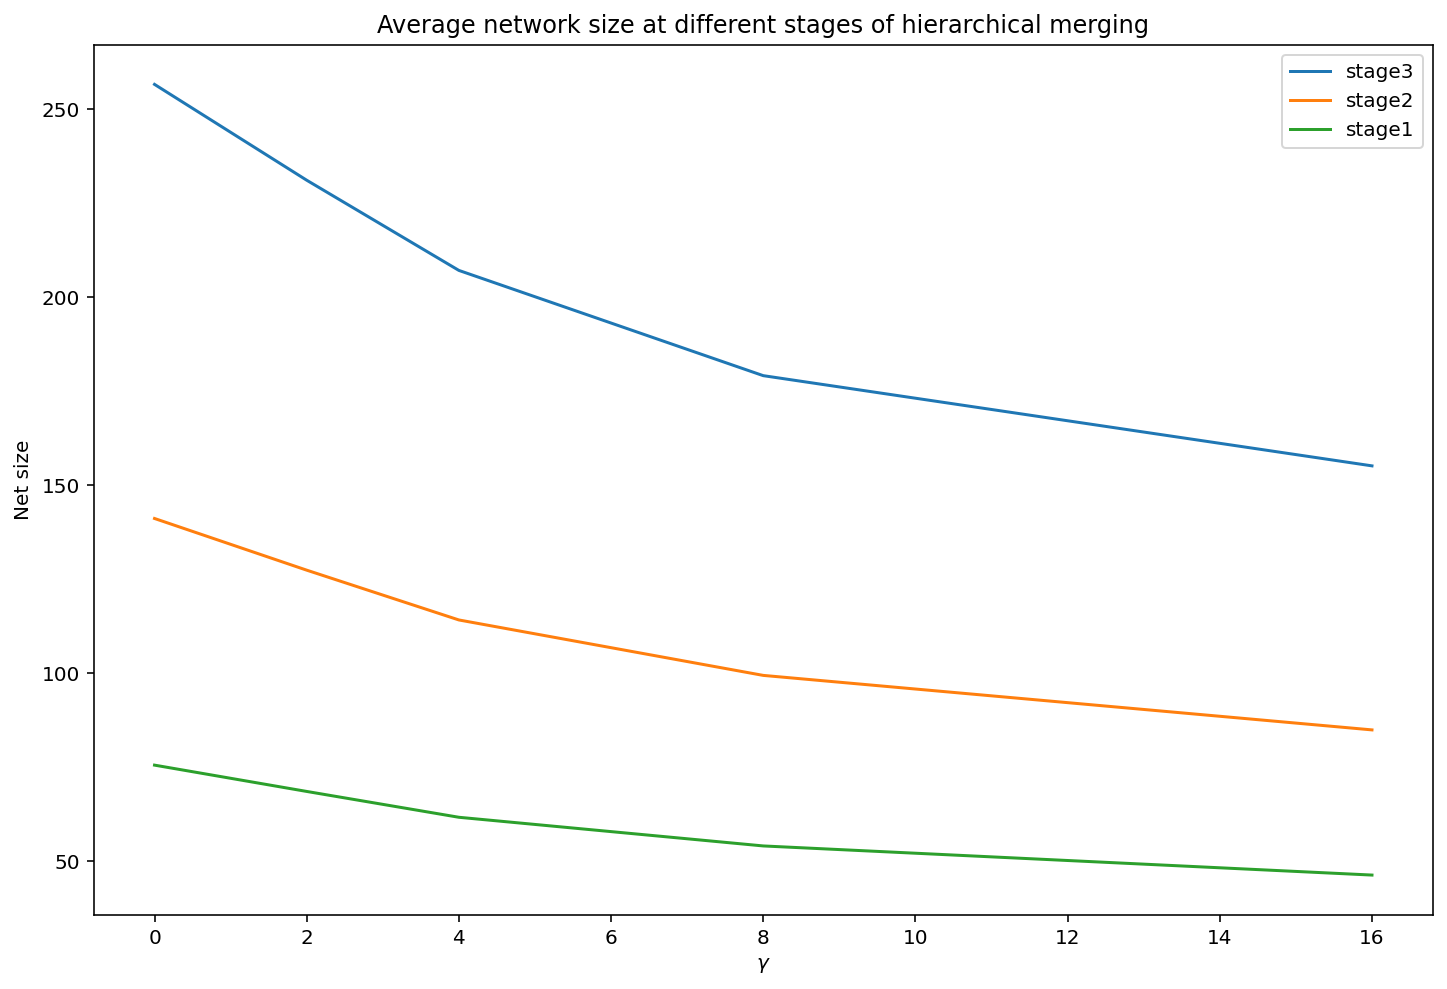

In [33]:
plt.figure(figsize=(12, 8))
plt.title('Average network size at different stages of hierarchical merging')
for stage in range(3,0, -1):
    plt.plot(rdf[f"size_stage{stage}"], label=f"stage{stage}")
plt.legend();
plt.xlabel(r"$\gamma$")
plt.ylabel("Net size");

In [ ]:
plt.plot(rdf.one_shot_anchors/(num_parts*part_size),'-o', label='oneshot anchors')
plt.plot(rdf.hierarchical_anchors/(num_parts*part_size),'-x', label='hierarchical anchors')
plt.legend();
plt.xlabel(r"$\gamma$")
plt.ylabel("Compression ration");
plt.title('Compression');

## Complexity of network calculation

Hypothesis: 

network calculation complexity: O(size) + O(compresion*size^2)

Outcome:
We get a pretty decent fit of $f(x) = a*x + b*x^2$ 
Parameters: a=26.13162864  b=0.06917811 

(contribution of the quadratic is small)

In [41]:
from scipy.optimize import curve_fit

In [466]:
num_parts = 1
gamma = 8
res = dict()
for part_size in tqdm([100, 200, 300, 400, 500, 800, 1000, 2000]):
    part = get_part_indexes(afs, num_parts, part_size)[0]
    mydistance.calls = 0
    vn = create_voting_net(gamma=gamma, apns=part, distance=lambda x,y: mydistance(x,y, afs), 
                            classifier=lambda x: lcl(x, labs))
    res[part_size] = [mydistance.calls, len(vn.keys())]


In [51]:
#cpx = pd.DataFrame.from_dict(res, orient='index', columns=['ops', 'net_size'])
#cpx.to_csv('res/merging-complexity.csv')
cpx = pd.read_csv('res/merging-complexity.csv', index_col=0)#, columns=['ops', 'net_size'])
cpx

,ops,net_size
100,1830,59
200,7027,111
300,13439,151
400,20845,184
500,28343,211
800,64243,322
1000,99102,401
2000,328358,726


In [52]:
# O(size) + O(compresion*size^2)
def func(x, a, b):
    return a*x + b*x**2


In [53]:
popt, pcov = curve_fit(func, cpx.index, cpx.ops)
print(popt)

[26.13162864  0.06917811]


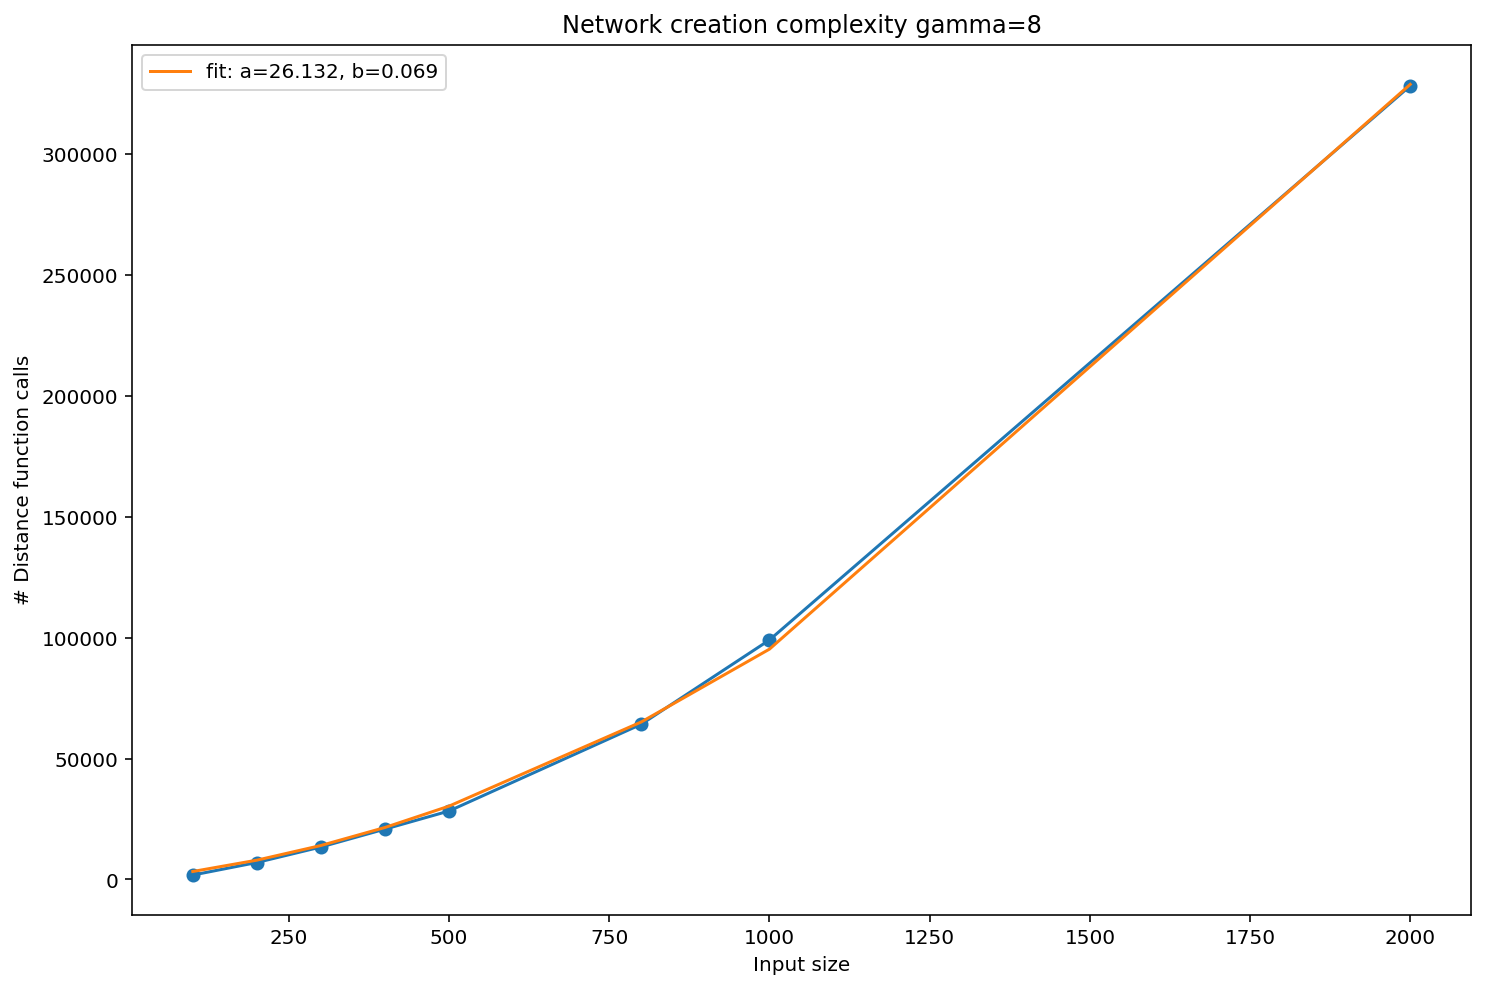

In [56]:
gamma = 8
plt.figure(figsize=(12,8))
plt.plot(cpx.ops, '-o')
plt.plot(cpx.index, func(cpx.index, *popt), label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend()
plt.xlabel('Input size')
plt.ylabel('# Distance function calls');
plt.title(f"Network creation complexity {gamma=}");

In [407]:
# how much compression is done by merging
part_size = 100
num_parts = 4
gamma = 8

parts = get_part_indexes(afs, num_parts, part_size)
vnets = [create_voting_net(gamma=gamma, apns=part, distance=lambda x,y: adf(x,y, afs), classifier=lambda x: lcl(x, labs)) for part in parts]

In [422]:
compression = sum([len(v.keys()) for v in vnets])/400
print(f"Network creation preserves {100.0*compression:0.4}% of input points")

Network creation preserves 54.75% of input points


In [412]:
ons = merge_voting_nets_new(nets=vnets, distance=lambda x,y: mydistance(x,y, afs), gamma=gamma)

In [421]:
merging_compression = len(ons.keys())/sum([len(v.keys()) for v in vnets])
print(f"Merged network preserves {100.0*merging_compression:0.4}% of input anchors")

Merged network preserves 83.11% of input anchors


## Network calculation in worst case
Estimation of difference between complexity of network creation for "normal" data as input and networks (anchors) as input. 

The later do require more computation, the square part of complexity function contributes much more. 

In [535]:
num_parts = 20
part_size = 200
parts = get_part_indexes(afs, num_parts, part_size)


In [519]:
gamma = 8
print(gamma)

8


In [536]:
vnets = [create_voting_net(gamma=gamma, apns=part, distance=mydistance, classifier=lambda x: lcl(x, labs)) for part in parts]

In [538]:
comres = dict()
for i in tqdm(range(1,len(vnets))):
    input_data = list()
    for net in vnets[:i]:
        input_data +=list(net.keys())
    mydistance.calls = 0
    out = create_voting_net(gamma=gamma, apns=input_data, distance=mydistance, classifier=lambda x: lcl(x, labs))
    comres[len(input_data)] = mydistance.calls

In [44]:
#wcp = pd.DataFrame.from_dict(comres, orient='index', columns=['ops'])
#wcp.to_csv('res/complexity-worstcaseest.csv')
wcp = pd.read_csv('res/complexity-worstcaseest.csv', index_col=0)
cpx = pd.read_csv('res/merging-complexity.csv', index_col=0 ) #=['ops', 'net_size'])

In [45]:
#[43.85528615  0.21237893]
#[26.13162864  0.06917811]
popt, pcov = curve_fit(func, cpx.index, cpx.ops)
popt2, pcov2 = curve_fit(func, wcp.index, wcp.ops)
print('New fit (worst case): ', popt2)
print('Old fit (normal case):', popt)

New fit (worst case):  [85.58687258  0.19441449]
Old fit (normal case): [26.13162864  0.06917811]


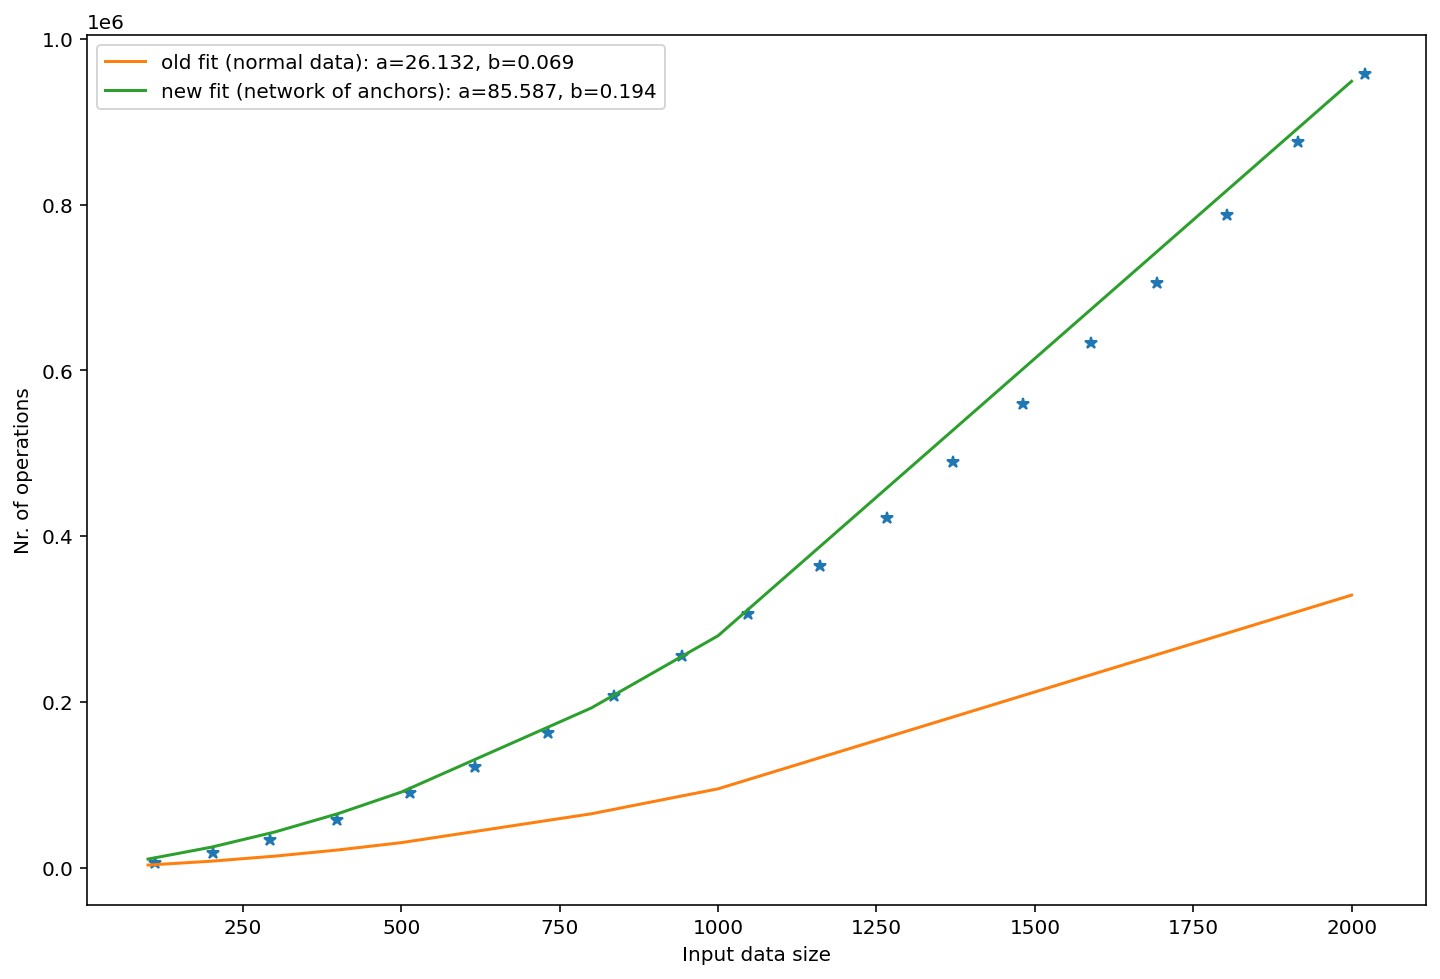

In [49]:
plt.figure(figsize=(12,8))
plt.plot(wcp.ops, '*')
plt.plot(cpx.index, func(cpx.index, *popt), label='old fit (normal data): a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(cpx.index, func(cpx.index, *popt2), label='new fit (network of anchors): a=%5.3f, b=%5.3f' % tuple(popt2))
plt.xlabel('Input data size')
plt.ylabel('Nr. of operations')
plt.legend();

## Complexity for artificla data

In [24]:

from tqdm.notebook import tqdm
from sklearn.datasets import make_blobs

def generate_random_points(n_points: int, max_x: int=100, max_y: int=100):
    return list(zip(np.random.randint(0, max_x, n_points), np.random.randint(0, max_y, n_points)))

def generate_random_reals(n_points: int, max_x: int=100, max_y: int=100):
    return list(zip(np.random.random(n_points)*max_x, np.random.random(n_points)*max_y))

def conc(n_points):
    X, y = make_blobs(n_points, n_features=2, center_box=[-200, 200], centers=50, cluster_std=16)
    return list(zip(X[:, 0], X[:, 1]))

In [53]:
@countin_decorator
def mydistance(i1,i2, pts):
    p1,p2 = pts[i1], pts[i2]
    
    v = [(x-y)**2 for x,y in zip(p1, p2)]
    return np.sqrt(sum(v))


def make_complexity_plot(point_generator):
    df = dict()
    for gamma in tqdm([0, 1, 2, 8, 16, 32, 64]):
        res = dict()
        for size in [100, 200, 300, 400, 500, 800, 1000, 2000]:
            pts = point_generator(size)
            mydistance.calls = 0
            nt = create_aggregating_net(gamma=gamma, apns=range(size),distance=lambda x,y: mydistance(x,y, pts))
            res[size] = [mydistance.calls, len(nt)]
        df[gamma] = pd.DataFrame.from_dict(res, orient='index', columns=['ops', 'anchors'])

    for gamma, dfs in df.items(): 
        plt.plot(dfs.index, dfs.ops, label=f"{gamma=}")

    plt.legend()
    return df

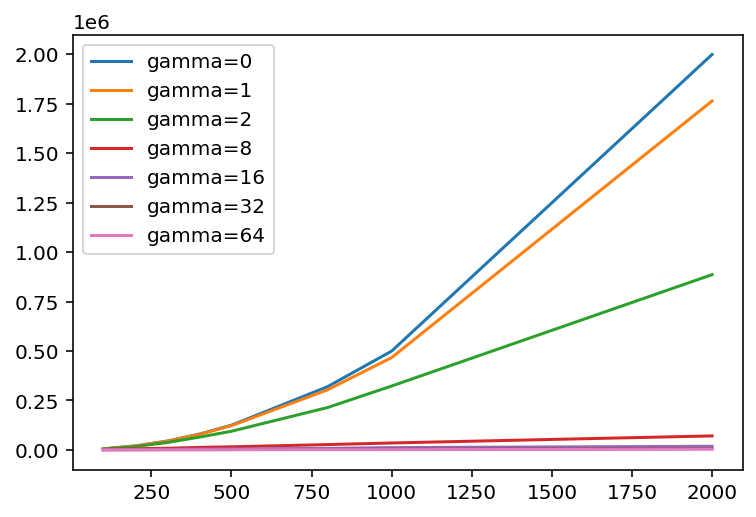

In [54]:
dri = make_complexity_plot(point_generator=generate_random_points)

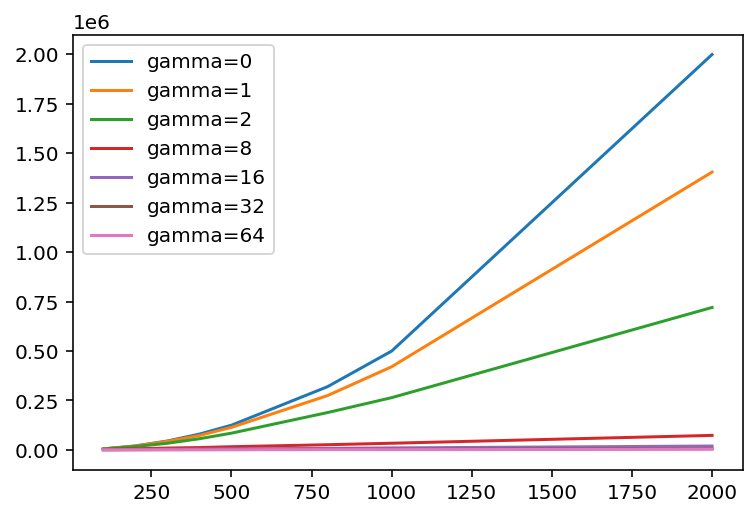

In [28]:
drr = make_complexity_plot(point_generator=generate_random_reals)

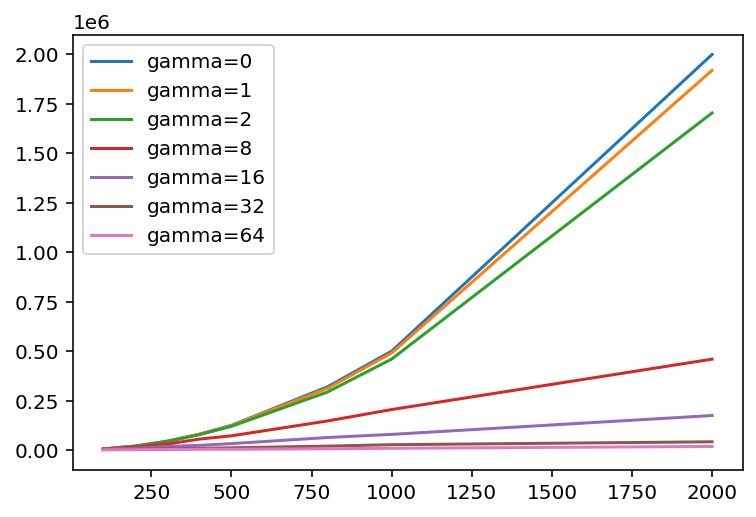

In [26]:
drc = make_complexity_plot(point_generator=conc)

In [29]:
def get_ops_for_size(df, size=2000):
    if not size in df[0].index:
        print(f"Incrrect {size=} {df[0].index}")
        return
    
    res = dict()
    for gamma, m in df.items():
        res[gamma] = m.loc[size]['ops']

    mf = pd.DataFrame.from_dict(res, orient='index', columns=['ops'])
    return mf


In [37]:
from scipy.optimize import curve_fit

def func(x,a, b):
    return a*np.exp(b*x)

def fit_and_plot(mf):

    popt, pcov = curve_fit(func, mf.index, mf.ops)

    plt.figure(figsize=(12,8))
    plt.title("Network calculation complexity as function of gamma")
    plt.plot(mf.index, func(mf.index, *popt), label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    plt.plot(mf.index, mf.ops, '-o')
    plt.legend()
    plt.xlabel('gamma')
    plt.ylabel('ops')

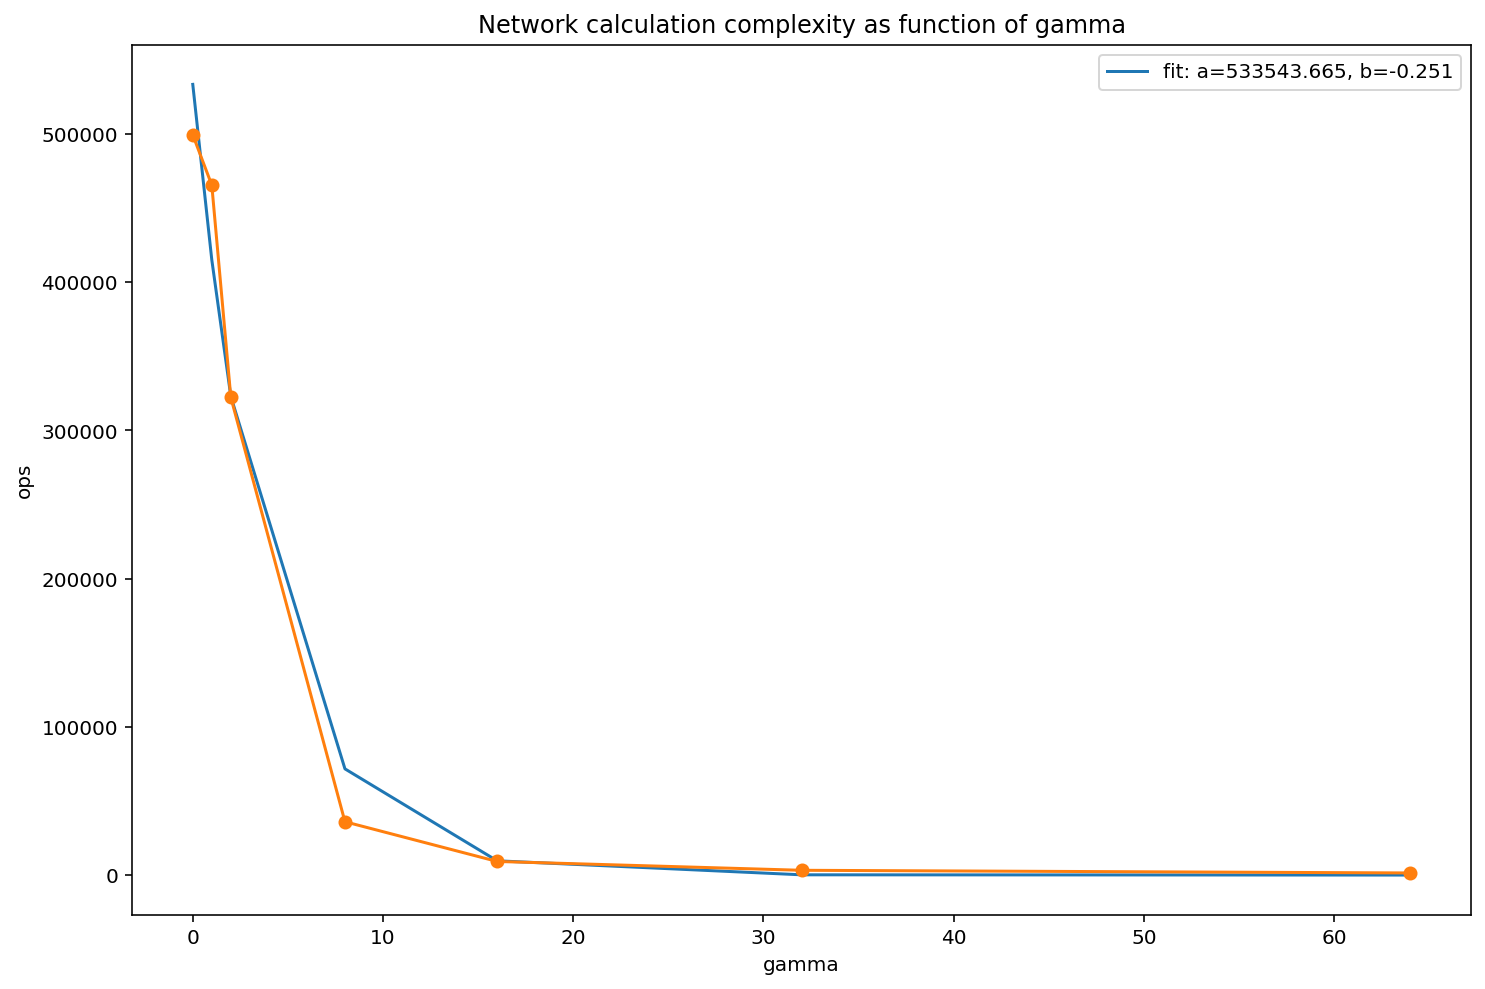

In [38]:
fit_and_plot(get_ops_for_size(dri, 1000))

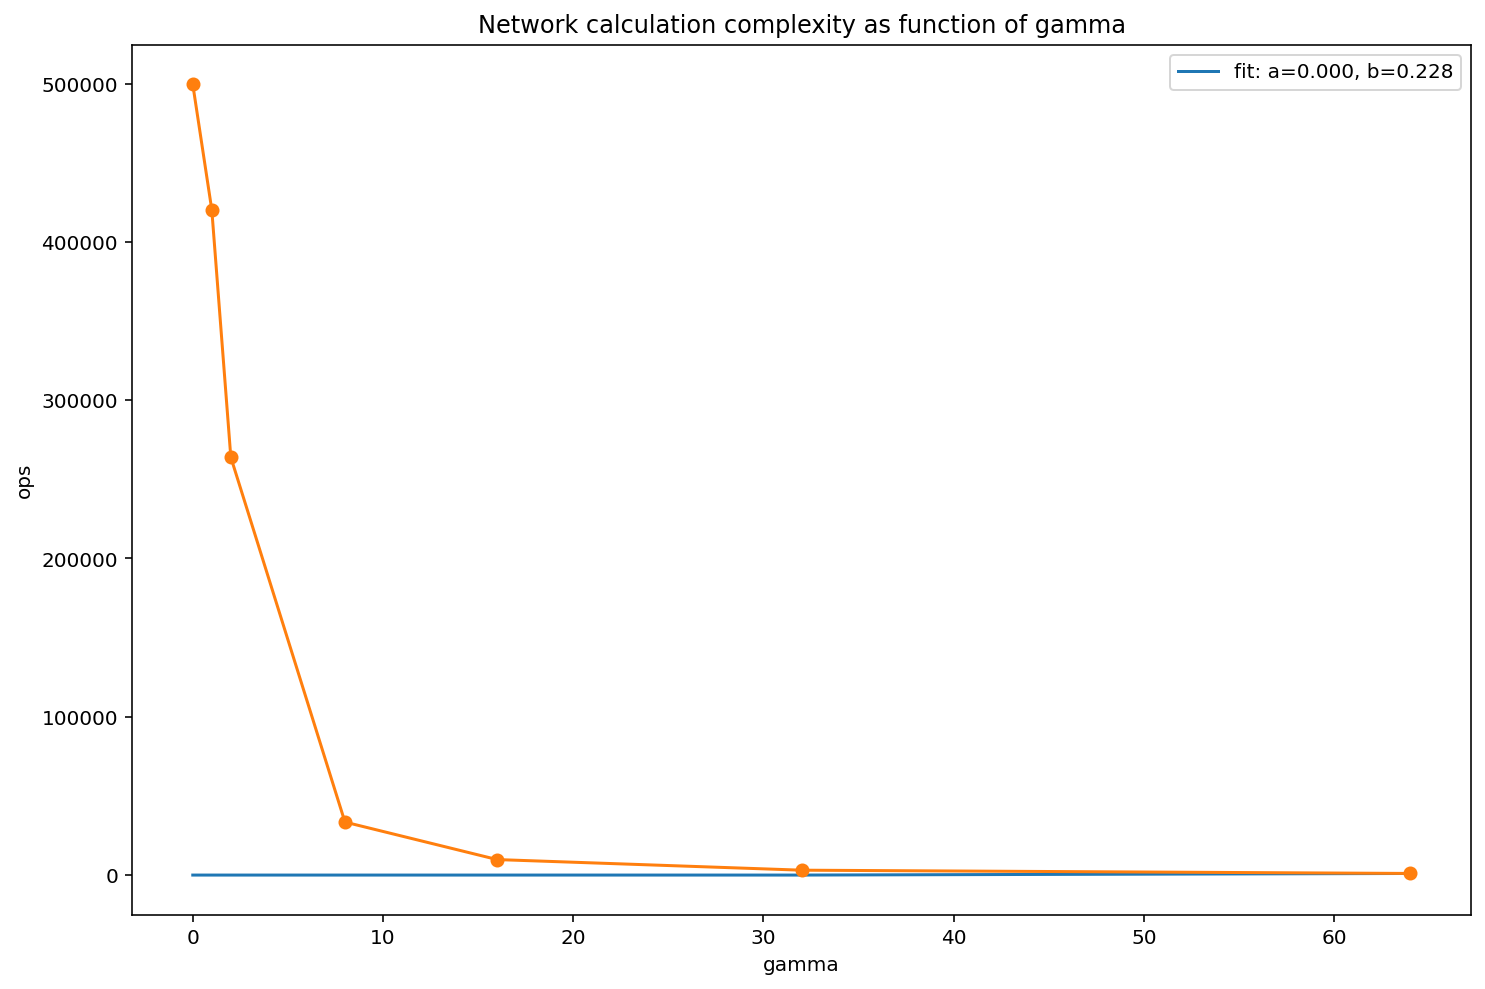

In [57]:
fit_and_plot(get_ops_for_size(drr, 1000))

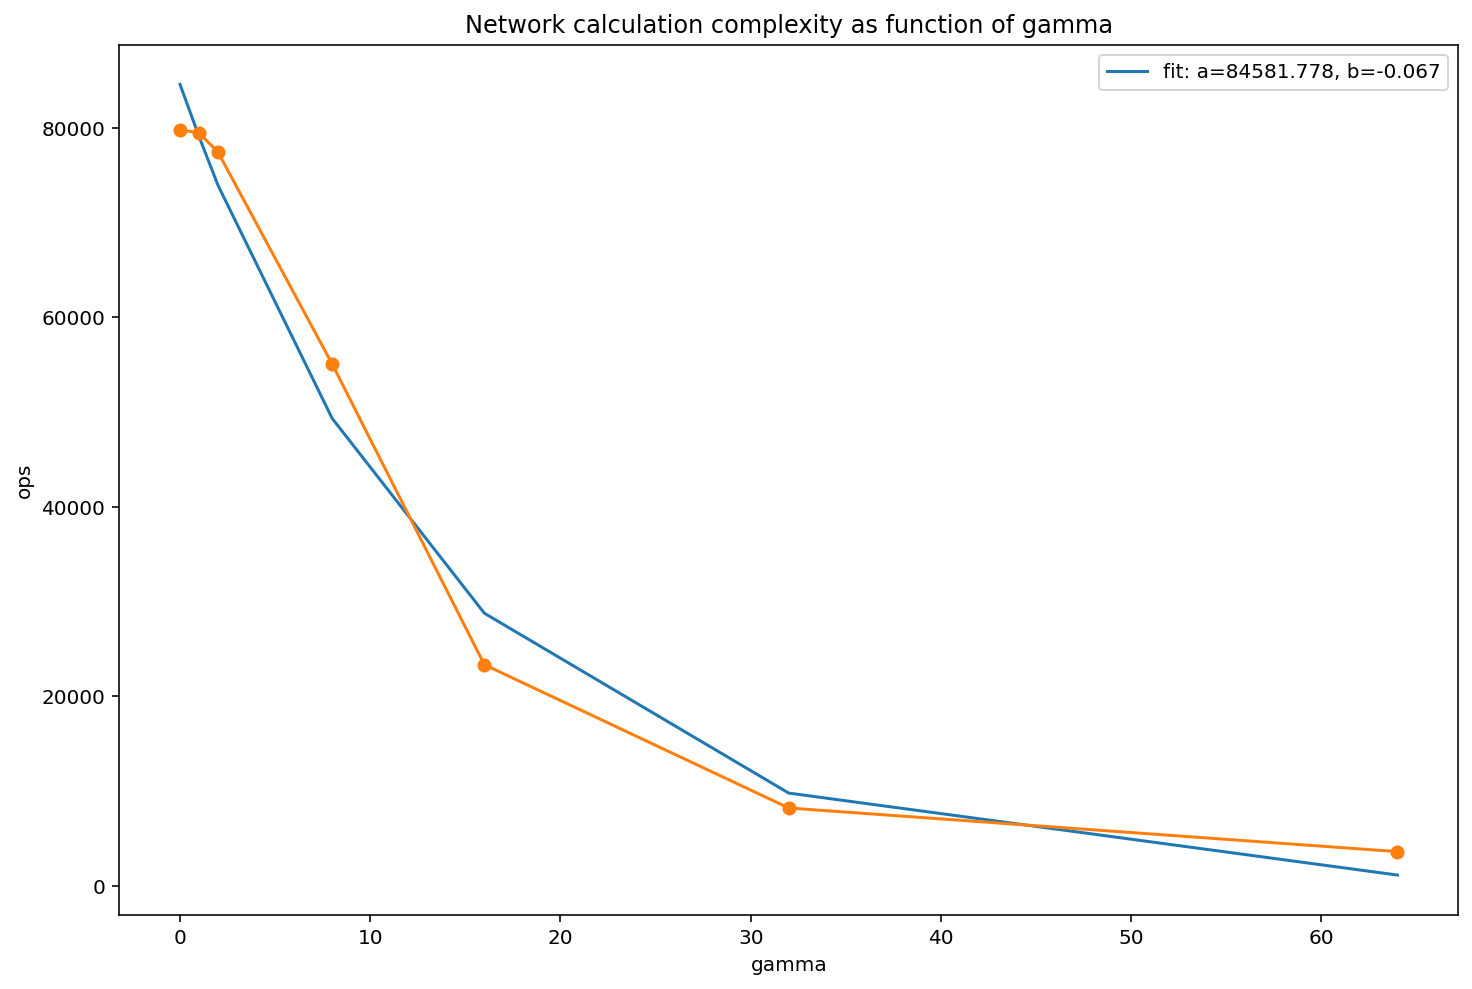

In [59]:
fit_and_plot(get_ops_for_size(drc, 400))